# Composite Figure

## Import package

In [13]:
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib import spines as sp
from matplotlib.colors import TwoSlopeNorm

## Figure: Longwave (CNTL - NCRF) + Temp. (CNTL)

### Load data

#### Load selected events

In [14]:
# file path
cntl_path: str = "/work/b11209013/2024_Research/MPAS/merged_data/CNTL/"
ncrf_path: str = "/work/b11209013/2024_Research/MPAS/merged_data/NCRF/"

# load selected events
## Load CNTL selected events
sel_events_cntl: dict       = np.load(
    "/home/b11209013/Bachelor_Thesis/CCKW_sel/Selected_Events/q1_sel_CNTL.npz",
    allow_pickle=True
    )
sel_time_cntl  : np.ndarray = sel_events_cntl["selected_events_time"]
sel_lon_cntl   : np.ndarray = sel_events_cntl["selected_events_lon"]

## Load NCRF selected events
sel_events_ncrf: dict       = np.load(
    "/home/b11209013/Bachelor_Thesis/CCKW_sel/Selected_Events/q1_sel_NCRF.npz",
    allow_pickle=True
    )
sel_time_ncrf  : np.ndarray = sel_events_ncrf["selected_events_time"]
sel_lon_ncrf   : np.ndarray = sel_events_ncrf["selected_events_lon"]

#### load MPAS dataset

In [15]:
# load MPAS data
data: dict[str, np.ndarray] = dict()

## load CNTL specific humidity
with nc.Dataset(f"{cntl_path}qv.nc") as f:
    dims: dict[str, np.ndarray] = dict(
        (key, np.array(f.variables[key][:]))
        for key in f.dimensions.keys()
    )

    lat_lim: np.ndarray = np.where(
        (dims["lat"] >= -5) & (dims["lat"] <= 5)
    )[0]

    dims["lat"]  = dims["lat"][lat_lim]
    dims["time"] = dims["time"][:360]

    data["qv_cntl"] = np.nanmean(np.array(f.variables["qv"][:360, :, lat_lim, :]) * 1000, axis=2)

## Load NCRF specific humidity
with nc.Dataset(f"{ncrf_path}qv.nc") as f:
    data["qv_ncrf"] = np.nanmean(np.array(f.variables["qv"][:360, :, lat_lim, :]) * 1000, axis=2)

### Remove climatology and Zonal mean

In [16]:
# remove climatology and zonal mean
data_rm_cli: dict[str, np.ndarray] = dict(
    (key, data[key] - np.mean(data[key], axis=(0, 2), keepdims=True))
    for key in data.keys()
)

## Events selection

In [17]:
data_sel: dict[str, np.ndarray] = dict(
    (key, [])
    for key in data_rm_cli.keys()
)
print(data_rm_cli["qv_cntl"].shape)
for t in range(sel_time_cntl.shape[0]): # for seleting time for CNTL
    for l in sel_lon_cntl[t]: # for selecting longitude in each time for CNTL
        data_sel["qv_cntl"].append(data_rm_cli["qv_cntl"][sel_time_cntl[t], :, l].T)

for t in range(sel_time_ncrf.shape[0]): # for seleting time for NCRF
    for l in sel_lon_ncrf[t]: # for selecting longitude in each time for NCRF
        data_sel["qv_ncrf"].append(data_rm_cli["qv_ncrf"][sel_time_ncrf[t], :, l].T)
    
# Composite the CCKWs events
for key in data_sel.keys():
    data_sel[key] = np.array(data_sel[key]).mean(axis=0)

(360, 38, 720)


### Composite

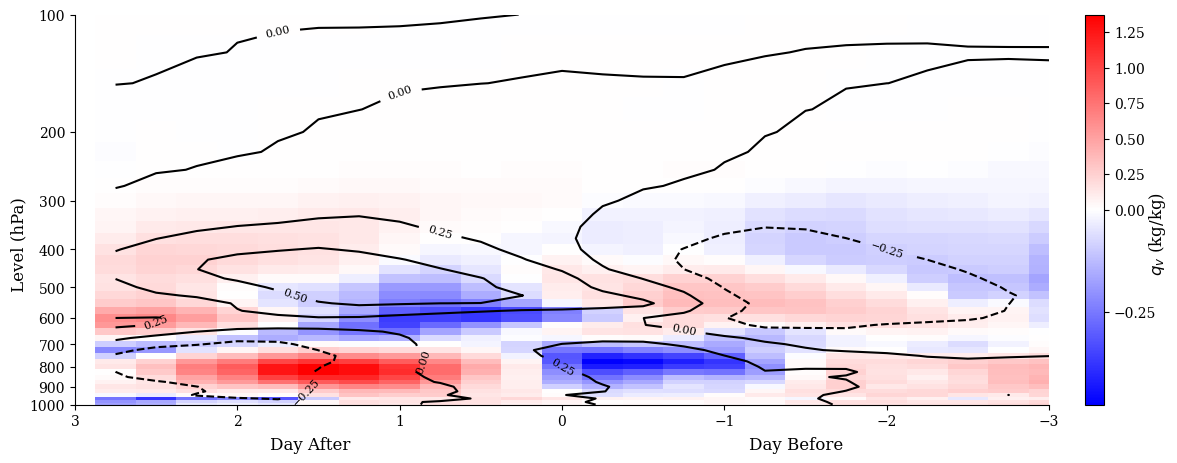

In [18]:
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(12, 5))
pc = plt.pcolormesh(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["qv_cntl"] - data_sel["qv_ncrf"], # difference between CNTL and NCRF
    cmap="bwr", norm = TwoSlopeNorm(vcenter=0)
    )
c1 = plt.contour(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["qv_cntl"],
    colors="k",
    levels=np.arange(-1.75, 1.51, 0.25)
    )
plt.yscale("log")
plt.xticks(np.linspace(-3, 3, 7))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.ylim(100, 1000)
plt.text(1.8, 1300, "Day After", fontsize=12)
plt.text(-1.15, 1300, "Day Before", fontsize=12)
plt.text(3.4, 500, "Level (hPa)", fontsize=12, rotation=90)
plt.text(-3.6, 450, r"$q_v$ (kg/kg)", fontsize=12, rotation=90)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(pc, pad=0.03)
plt.clabel(c1, inline=True, fontsize=8)
plt.subplots_adjust(left=0.07, right=1.06, top=0.9, bottom=0.12)

axes = fig.gca()
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)

plt.savefig("qv_diff.png", dpi=300)